### Load Packages

In [1]:
from collections import defaultdict
from itertools import permutations, combinations
from time import time

import gurobipy as gp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Settings

In [2]:
# Function to pretty-print configuration and setup details
def pretty_print_setup(input_data, max_stops, num_nodes):
    print("Configuration and Setup Details:")
    print("-" * 40)
    print(f"Input Data (First 5 rows):\n{input_data.head()}")
    print(f"Maximum Stops: {max_stops}")
    print(f"Number of Nodes: {num_nodes-1}")
    print("-" * 40)

# Load customer data
input_data = pd.read_csv("manhattan_customers20.csv", index_col=0)

# Set the maximum number of stops
max_stops = 4

# Calculate the number of nodes (customers + depot)
num_nodes = input_data.shape[0]

# Pretty-print the setup information
pretty_print_setup(input_data, max_stops, num_nodes)

Configuration and Setup Details:
----------------------------------------
Input Data (First 5 rows):
     Location      Lat     Long
Id                             
1   Manhattan  40.7831 -73.9712
2   Customer1  40.7662 -73.9630
3   Customer2  40.7100 -73.9900
4   Customer3  40.7208 -74.0022
5   Customer4  40.7185 -74.0029
Maximum Stops: 4
Number of Nodes: 20
----------------------------------------


### Calculate Distance

In [3]:
# Calculates distance using Manhattan
def calculate_distance_manhattan(lat1, lon1, lat2, lon2):
    # Calculate the absolute differences
    dlat = abs(lat2 - lat1)
    dlon = abs(lon2 - lon1)
    
    # Sum up the absolute differences
    return dlat + dlon

In [4]:
# Create the distance matrix between every two locations
def create_distance_matrix(locations):
    distance_matrix = {}
    for ind1, loc1 in locations.iterrows():
        for ind2, loc2 in locations.iterrows():
            dist = calculate_distance_manhattan(loc1['Lat'], loc1['Long'], loc2['Lat'], loc2['Long'])
            distance_matrix[(ind1, ind2)] = dist
    return distance_matrix

### Cost and Savings

In [5]:
# Calculate the cost of each route
def calculate_cost(route_distance):
    return round(route_distance, 4)

In [6]:
def calculate_savings(distance_matrix, num_nodes):
    """Calculate and sort the savings between each pair of customers."""
    savings = {}
    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            saving = distance_matrix[(1, i)] + distance_matrix[(1, j)] - distance_matrix[(i, j)]
            savings[(i, j)] = saving
    return {k: v for k, v in sorted(savings.items(), key=lambda item: item[1], reverse=True)}

### Clarke-Wright Savings Algorithm

In [7]:
# Create the distance matrix using customer data
dist_matrix = create_distance_matrix(input_data)

# Create savings dictionary
savings_dict = calculate_savings(dist_matrix, num_nodes)

# Initialize an empty list to store the routes
all_routes = []

# Start merging routes based on maximum savings
while savings_dict:
    # Manually pop the maximum savings value and its associated node pair (i, j) CHECK CHECK
    max_item = max(savings_dict.items(), key=lambda x: x[1])
    (i, j) = max_item[0]
    del savings_dict[(i, j)]
    
    # Flags to indicate if nodes i and j are already in any route
    i_in_route = False
    j_in_route = False
    
    # The routes that contain nodes i and j
    i_route = None
    j_route = None
    
    # Search through all_routes to find routes that contain either i or j
    for route in all_routes:
        if i in route:
            i_in_route = True
            i_route = route
        if j in route:
            j_in_route = True
            j_route = route

    # Apply the logic based on the criteria
    if not i_in_route and not j_in_route:
        # First case: Create a new route [1, i, j, 1] only if it doesn't exceed max_stops
        if 2 <= max_stops:  # Two new stops are being added
            new_route = [1, i, j, 1]
            all_routes.append(new_route)


    elif i_in_route and not j_in_route:
        # Second case: Add j to the route containing i, if i is not an interior node and max_stops is not exceeded
        current_stops = (len(i_route) - 2)
        if (i_route[1] == i or i_route[-2] == i) and (current_stops < max_stops):
            i_route.insert(-1, j)


    elif j_in_route and not i_in_route:
        # Second case: Add i to the route containing j, if j is not an interior node and max_stops is not exceeded
        current_stops = (len(j_route) - 2)
        if (j_route[1] == j or j_route[-2] == j) and (current_stops < max_stops):
            j_route.insert(-1, i)


    elif i_in_route and j_in_route:
        # Third case: Check if i and j are in different routes and are exterior nodes, then merge if max_stops is not exceeded
        if i_route != j_route:
            if (i_route[1] == i or i_route[-2] == i) and (j_route[1] == j or j_route[-2] == j):
                combined_stops = (len(i_route) + len(j_route) - 4)
                if combined_stops <= max_stops:
                    new_route = i_route[:-1] + j_route[1:]
                    all_routes.remove(i_route)
                    all_routes.remove(j_route)
                    all_routes.append(new_route)

In [8]:
# Calculate the cost for each route in all_routes
route_costs = []
total_cost = 0

for route in all_routes:
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += dist_matrix.get((route[i], route[i + 1]), 0)
    cost = calculate_cost(total_distance)
    route_costs.append((route, cost))
    total_cost += cost

# Function to pretty-print the route costs and total cost
def pretty_print_costs(route_costs, total_cost):
    print("Route Costs:")
    for i, (route, cost) in enumerate(route_costs):
        print(f"  Route {i+1}: {route} -> Cost: {cost}")
    print(f"Total Cost: {total_cost}")

# Pretty-print the calculated costs
pretty_print_costs(route_costs, total_cost)

Route Costs:
  Route 1: [1, 4, 5, 20, 6, 1] -> Cost: 0.206
  Route 2: [1, 9, 11, 8, 10, 1] -> Cost: 0.192
  Route 3: [1, 3, 12, 21, 7, 1] -> Cost: 0.2146
  Route 4: [1, 14, 15, 16, 17, 1] -> Cost: 0.1072
  Route 5: [1, 13, 18, 2, 19, 1] -> Cost: 0.1122
Total Cost: 0.832


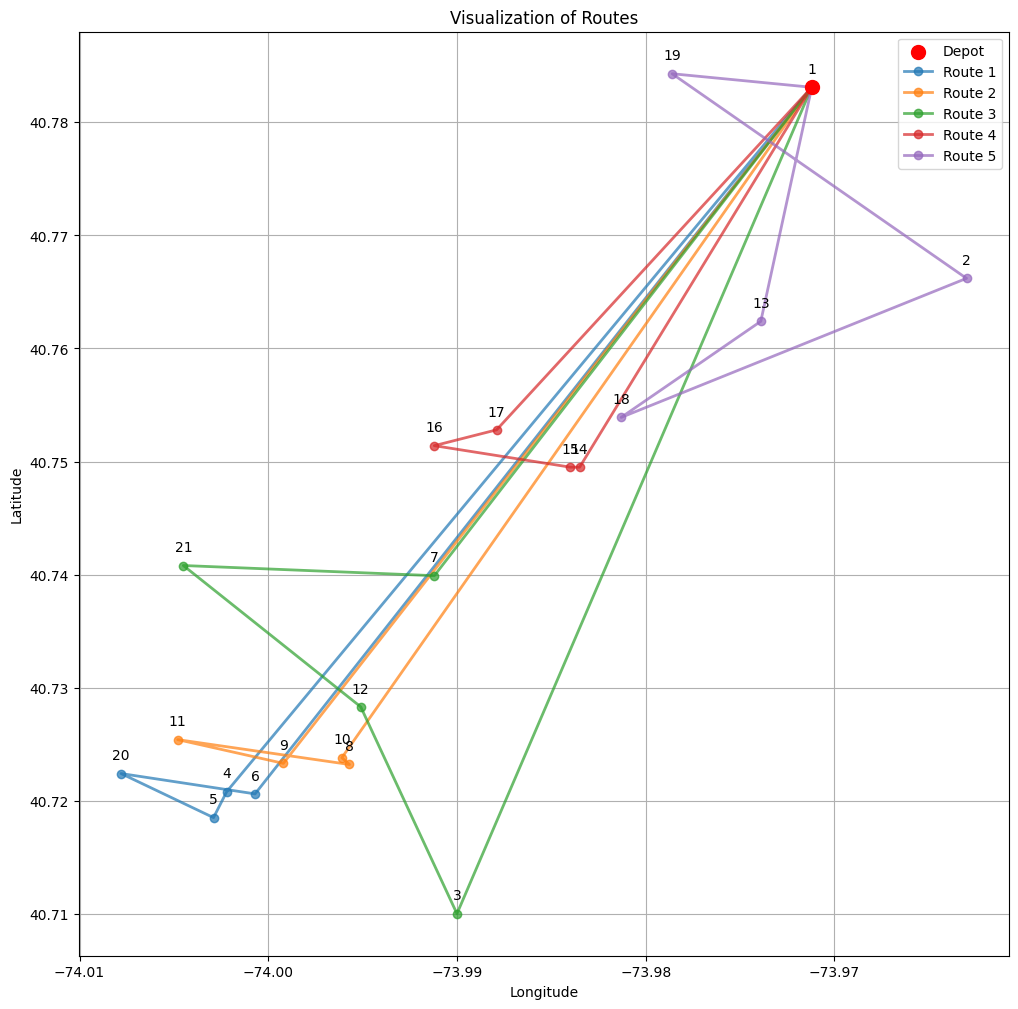

In [9]:
def plot_routes(input_data, all_routes):
    plt.figure(figsize=(12, 12))

    # Highlight the depot
    depot_lat = input_data.loc[1, 'Lat']
    depot_lon = input_data.loc[1, 'Long']
    plt.scatter(depot_lon, depot_lat, c='red', label='Depot', zorder=5, s=100)
    
    # Plot each route
    for route_index, route in enumerate(all_routes):
        lat = [input_data.loc[node, 'Lat'] for node in route]
        lon = [input_data.loc[node, 'Long'] for node in route]
        
        plt.plot(lon, lat, marker='o', linestyle='-', linewidth=2, alpha=0.7, label=f'Route {route_index + 1}')
        
    # Annotate each point with the corresponding node number
    for ind, row in input_data.iterrows():
        plt.annotate(f"{ind}", (row['Long'], row['Lat']), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title('Visualization of Routes')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the plot function
plot_routes(input_data, all_routes)

### Nearest Neighbor Heuristic

In [10]:
# Initialize variables for Nearest Neighbor heuristic
nn_all_routes = []
nn_visited_nodes = set()  # To keep track of visited nodes
nn_current_node = 1  # Start at the depot

# Loop to create routes using NN heuristic
while len(nn_visited_nodes) < num_nodes - 1:  # -1 to exclude the depot
    nn_route = [1]  # Start each route at the depot
    nn_stops = 0  # Reset the stops count for this route
    
    while nn_stops < max_stops and len(nn_visited_nodes) < num_nodes - 1:
        nn_nearest_distance = float('inf')  # Initialize to a large value
        nn_nearest_node = None  # Initialize to None
        
        # Find the nearest unvisited node to the current node
        for next_node in range(2, num_nodes + 1):  # Start from 2 to exclude the depot
            if next_node not in nn_visited_nodes and dist_matrix.get((nn_current_node, next_node), 0) < nn_nearest_distance:
                nn_nearest_distance = dist_matrix[nn_current_node, next_node]
                nn_nearest_node = next_node
        
        # Update route and visited_nodes
        nn_route.append(nn_nearest_node)
        nn_visited_nodes.add(nn_nearest_node)
        nn_current_node = nn_nearest_node
        nn_stops += 1  # Increase the stops count
        
    # Return to the depot to complete the route
    nn_route.append(1)
    nn_all_routes.append(nn_route)
    nn_current_node = 1  # Reset to the depot for the next route

In [11]:
# Calculate the cost for each route in nn_all_routes
nn_route_costs = []
nn_total_cost = 0  # To keep track of the sum of all route costs

for route in nn_all_routes:
    nn_total_distance = 0  # Reset the total distance for this route
    for i in range(len(route) - 1):
        nn_total_distance += dist_matrix.get((route[i], route[i + 1]), 0)
    nn_cost = calculate_cost(nn_total_distance)  # Calculate the cost for this route
    nn_route_costs.append((route, nn_cost))  # Append the route and its cost to the list
    nn_total_cost += nn_cost  # Add the cost of this route to the total cost

# Pretty-print the calculated costs
pretty_print_costs(nn_route_costs, nn_total_cost)


Route Costs:
  Route 1: [1, 19, 13, 2, 18, 1] -> Cost: 0.1198
  Route 2: [1, 14, 15, 17, 16, 1] -> Cost: 0.11
  Route 3: [1, 7, 21, 11, 20, 1] -> Cost: 0.1964
  Route 4: [1, 12, 10, 8, 9, 1] -> Cost: 0.1766
  Route 5: [1, 3, 6, 4, 5, 1] -> Cost: 0.2142
Total Cost: 0.817


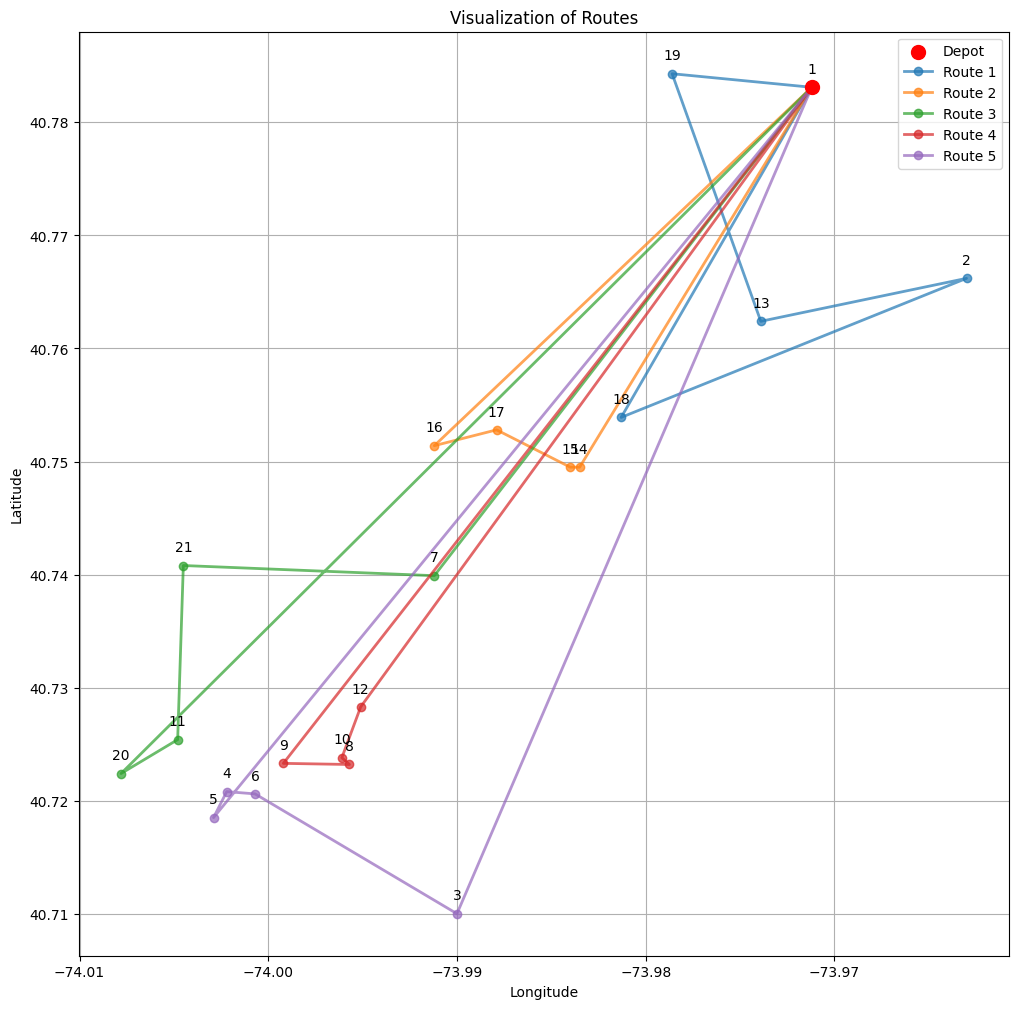

In [12]:
# Run the plot function
plot_routes(input_data, nn_all_routes)